## Import and setup

In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torchvision;
import tensorflow_datasets as tfds;
from PIL import Image;
from functions import *

# Define DEVICE with priority: MPS > CUDA > CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

mps


In [2]:
dataset = tfds.load("cats_vs_dogs", as_supervised=True, split=['train[:80%]', 'train[80%:]'])

KeyboardInterrupt: 

## Train simple CNN

### Understand datatype of dataset


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
train_set = dataset[0]
test_set = dataset[1]

# Show some images
print("Train set type: ", type(train_set))
instance = next(iter(train_set))
print("Instance type", type(instance))
print("Instance length: ", len(instance))
print("Train set image type: ", type(instance[0]))
print("Train set image shape: ", instance[0].shape)
plt.imshow(instance[0])

NameError: name 'dataset' is not defined

### Setup 


In [ ]:
# Define transormations
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Train and test sets
train_set = ConversionToTorchDataset(dataset[0], transform=train_transform)
test_set = ConversionToTorchDataset(dataset[1], transform=test_transform)

# Train and test loaders
train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=32,
                                            shuffle=True,
                                            drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set,
                                           batch_size=32,
                                           shuffle=False,
                                           drop_last=False)


2025-04-23 12:12:32.655299: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-23 12:12:40.602511: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-23 12:12:42.650667: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### CNN

In [ ]:
class Classifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = torch.nn.Sequential(
        self.make_block(3, 16),
        self.make_block(16, 32),
        self.make_block(32, 64),
        self.make_block(64, 128),
        self.make_block(128, 256),
        torch.nn.AdaptiveAvgPool2d(1)
    )

    # Linear + Sigmoid
    self.classifier = torch.nn.Sequential(
        torch.nn.Linear(256, 1),
        torch.nn.Sigmoid()
    )

  def forward(self, x):
    features = torch.flatten(self.feature_extractor(x), 1)
    probs = self.classifier(features)
    return probs

  def make_block(self, in_channels, out_channels):
    # Conv -> Norm -> ReLU -> Conv -> Norm -> Relu
    block = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels,
                        out_channels,
                        kernel_size=3,
                        padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(),
        torch.nn.Conv2d(out_channels,
                        out_channels,
                        kernel_size=3,
                        padding=1,
                        stride=2), # works as maxpooling
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU()
    )
    return block

classifier = Classifier()

### Train

In [ ]:
# Define DEVICE with priority: MPS > CUDA > CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

classifier.to(DEVICE)

loss_fun = torch.nn.BCELoss()
loss_fun.to(DEVICE)

LR = 0.001
optimizer = torch.optim.Adam(classifier.parameters(), lr=LR)

mps


In [ ]:
EPOCHS = 10

step = 0
for epoch in range(EPOCHS):
  # Training loop
  for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Reset the gradient
    optimizer.zero_grad()

    # Compute the prob
    probs = classifier(images)

    # Compute the loss
    loss = loss_fun(probs, labels.float().unsqueeze(1))

    # Backward step
    loss.backward()

    # Optimizer step
    optimizer.step()

    step += 1
    if step % 50 == 0:
      acc = ((probs > 0.5).long() == labels.unsqueeze(1)).float().mean()
      print(f"{step}[{epoch}]: loss {loss.item():.4f}   acc:{100*acc:.1f}")

  # Save the model parameters every epoch
  torch.save(classifier.state_dict(), "classifier.pt")

50[0]: loss 0.6459   acc:62.5
100[0]: loss 0.7296   acc:43.8
150[0]: loss 0.5416   acc:75.0
200[0]: loss 0.7062   acc:53.1
250[0]: loss 0.6685   acc:56.2
300[0]: loss 0.5831   acc:68.8
350[0]: loss 0.5582   acc:75.0
400[0]: loss 0.6217   acc:71.9
450[0]: loss 0.6301   acc:62.5
500[0]: loss 0.7871   acc:46.9
550[0]: loss 0.5528   acc:68.8
600[1]: loss 0.6957   acc:59.4
650[1]: loss 0.5099   acc:75.0
700[1]: loss 0.5507   acc:75.0
750[1]: loss 0.4912   acc:78.1
800[1]: loss 0.5557   acc:68.8
850[1]: loss 0.4025   acc:84.4
900[1]: loss 0.5859   acc:75.0
950[1]: loss 0.5033   acc:81.2
1000[1]: loss 0.5069   acc:71.9
1050[1]: loss 0.5090   acc:75.0
1100[1]: loss 0.4957   acc:75.0
1150[1]: loss 0.3708   acc:87.5
1200[2]: loss 0.5499   acc:78.1
1250[2]: loss 0.6589   acc:71.9
1300[2]: loss 0.5954   acc:71.9
1350[2]: loss 0.3090   acc:87.5
1400[2]: loss 0.4831   acc:78.1
1450[2]: loss 0.3966   acc:81.2
1500[2]: loss 0.4782   acc:75.0
1550[2]: loss 0.4399   acc:87.5
1600[2]: loss 0.3816   acc:8

### Evaluation

In [ ]:
# Evaluation loop
correct = 0
total = 0

classifier.eval() # Some modules in the network may behave differently in evaluation or training so we have to specify the mode we want the model to be in
with torch.no_grad(): # save time because it doesn't compute the gradient in each step
  for images, labels in test_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Compute the prob
    probs = classifier(images)
    correct += ((probs > 0.5).long() == labels.unsqueeze(1)).sum().item()
    total += len(labels)
classifier.train()

acc = correct / total
print(f"Accuracy: {100*acc:.2f}%")

Accuracy: 92.00%


## Segmenting part

### Load model

In [ ]:
# Define DEVICE with priority: MPS > CUDA > CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

mps


In [ ]:
# Load the saved model parameters
classifier.load_state_dict(torch.load("classifier.pt", map_location=DEVICE))
classifier.to(DEVICE)

Classifier(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

### Start

In [ ]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage import img_as_float

In [ ]:
from functions import *

# Implementing Quickshift segmentation
images = ConversionToTorchDataset(dataset[0].take(30))

segments_list = create_segments(images)

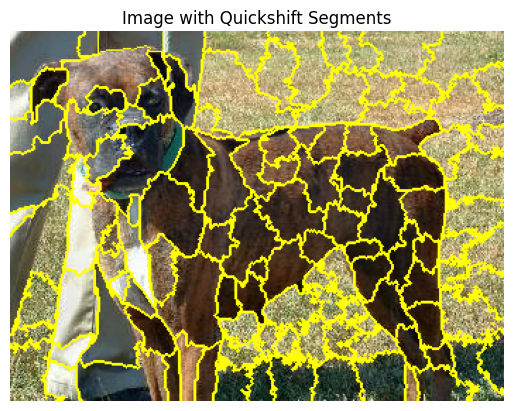

In [ ]:
# Show segmentation
image = images[0][0]
segments = segments_list[0]
show_segmented_images(image, segments)

## SEDC Algorithm

In [ ]:
image.shape, image.dtype

(torch.Size([3, 262, 350]), torch.float32)

In [ ]:
## Utility functions
#def pred_score(image, classifier, transform = None):
#    # Image conversion and transformation
#    if transform:
#        image = to_pil_image(image)
#        transformed_image = test_transform(image)
#
#    transformed_image = transformed_image.unsqueeze(0).to(DEVICE) 
#    classifier.to(DEVICE)
#
#    classifier.eval()
#    with torch.no_grad():
#        output = classifier(transformed_image)
#        score = output.item()
#        pred = 1 if score > 0.5 else 0
#    classifier.train()
#
#    if pred == 0:
#        score = 1 - score
#    
#    return pred, score
#
#
#
#def remove_segment(image, segments, segment_ids, fill_technique=None):
#    if fill_technique == None:
#        fill = 0
#    else:
#        pass # Implement other fill techniques if needed 
#    
#    # If one segment is provided, transform into a list
#    if isinstance(segment_ids, int):  
#        segment_ids = [segment_ids]
#
#    mask = np.isin(segments, segment_ids)  # Create boolean mask
#    mask_tensor = torch.from_numpy(mask).to(image.device)  # Convert to tensor
#    mask_tensor = mask_tensor.unsqueeze(0).expand_as(image)  # Expand to match image dimensions
#    
#    image_copy = image.clone()
#
#    image_copy[mask_tensor] = fill
#
#    return image_copy
#
#
#
#def EdC(image, segments, segment_ids):
#    # If one segment is provided, transform into a list
#    if isinstance(segment_ids, int):  
#        segment_ids = [segment_ids]
#
#    mask = np.isin(segments, segment_ids)  # Create boolean mask
#    mask_tensor = torch.from_numpy(mask).to(image.device)  # Convert to tensor
#    mask_tensor = mask_tensor.unsqueeze(0).expand_as(image)  # Expand to match image dimensions
#    
#    image_copy = image.clone()
#
#    image_copy[~mask_tensor] = 0
#
#    return image_copy


In [ ]:
from functions import *

In [ ]:
removed_image = remove_segment(image, segments, 3)

In [ ]:
edc = EdC(image, segments, 3)

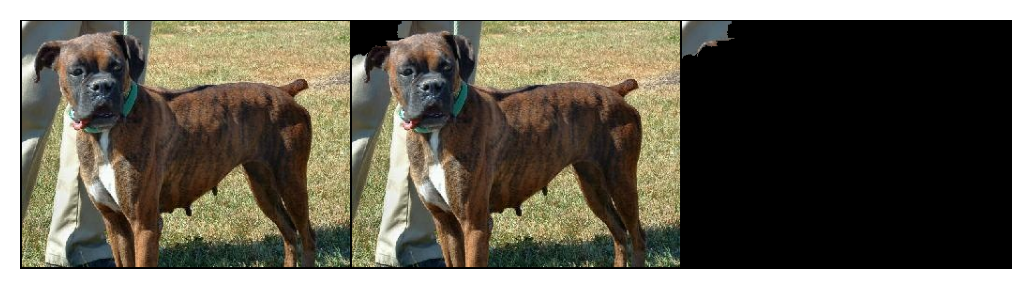

In [ ]:
show_batch([image, removed_image, edc])

In [ ]:
#def SEDC (image, classifier, segments, transform=None, max_iter=20):
#    # Image prediction and score
#    c, p_c = pred_score(image, classifier, transform)
#    # List of EdCs
#    R = []
#    # List of combinations to expand on
#    C = []
#    # List of predicted class score reduction
#    P = []
#
#    # List of segment ids
#    segment_ids = np.unique(segments)
#
#    # Support percentage of segments
#    if max_iter < 1:
#        iters = int(len(segment_ids) * max_iter)
#        max_iter = iters
#
#    # First loop
#    for id in segment_ids:
#        # Remove one segment
#        new_image = remove_segment(image, segments, id)
#        # New prediction and new score
#        c_new, p_c_new = pred_score(new_image, classifier, transform)
#        
#        if c_new != c:
#            # If the class changes, add the index of the region to R
#            R.append(id)
#        else:
#            # If the class doesn't change, add the index to C and compute the score reduction
#            C.append(id)
#            P.append(p_c - p_c_new)
#    
#    # While loop if no segment alone changed the classification
#    iter = 0
#    while not R:
#        # Picking the id of the best score reduction segment
#        k = np.argmax(P)
#        if iter == 0:
#            best = []
#            best.append(C[k])
#        else:
#            best = C[k]
#
#        # All expansions of "best" with one segment
#        best_set = []
#        for id in segment_ids:
#            if id not in best:
#                temp = best.copy()
#                temp.append(id)
#                best_set.append(temp)
#        # Pruning step
#        C.pop(k)
#        P.pop(k)
#        # Second loop
#        for id_list in best_set:
#            # Remove the segments
#            new_image = remove_segment(image, segments, id_list)
#            # New prediction and new score
#            c_new, p_c_new = pred_score(new_image, classifier, transform)
#            
#            if c_new != c:
#                # If the class changes, add the index of the region to R
#                R.append(id_list)
#            else:
#                # If the class doesn't change, add the index to C and compute the score reduction
#                C.append(id_list)
#                P.append(p_c - p_c_new)
#
#        # Output control
#        iter += 1
#        print(f"Current iter {iter} (list of segments length)")
#        if iter >= max_iter:
#            print("Max iterations reached")
#            break
#
#    return R

In [ ]:
from classes import *

result = SEDC(image, classifier, segments, transform=test_transform)

print(result)

Current iter 1 (list of segments length)
Current iter 2 (list of segments length)
Current iter 3 (list of segments length)
Current iter 4 (list of segments length)
Current iter 5 (list of segments length)
Current iter 6 (list of segments length)
Current iter 7 (list of segments length)
Current iter 8 (list of segments length)
[[np.int64(28), np.int64(79), np.int64(65), np.int64(50), np.int64(9), np.int64(76), np.int64(36), np.int64(45), np.int64(0)], [np.int64(28), np.int64(79), np.int64(65), np.int64(50), np.int64(9), np.int64(76), np.int64(36), np.int64(45), np.int64(1)], [np.int64(28), np.int64(79), np.int64(65), np.int64(50), np.int64(9), np.int64(76), np.int64(36), np.int64(45), np.int64(2)], [np.int64(28), np.int64(79), np.int64(65), np.int64(50), np.int64(9), np.int64(76), np.int64(36), np.int64(45), np.int64(3)], [np.int64(28), np.int64(79), np.int64(65), np.int64(50), np.int64(9), np.int64(76), np.int64(36), np.int64(45), np.int64(4)], [np.int64(28), np.int64(79), np.int64(65)

In [ ]:
len(result)

45

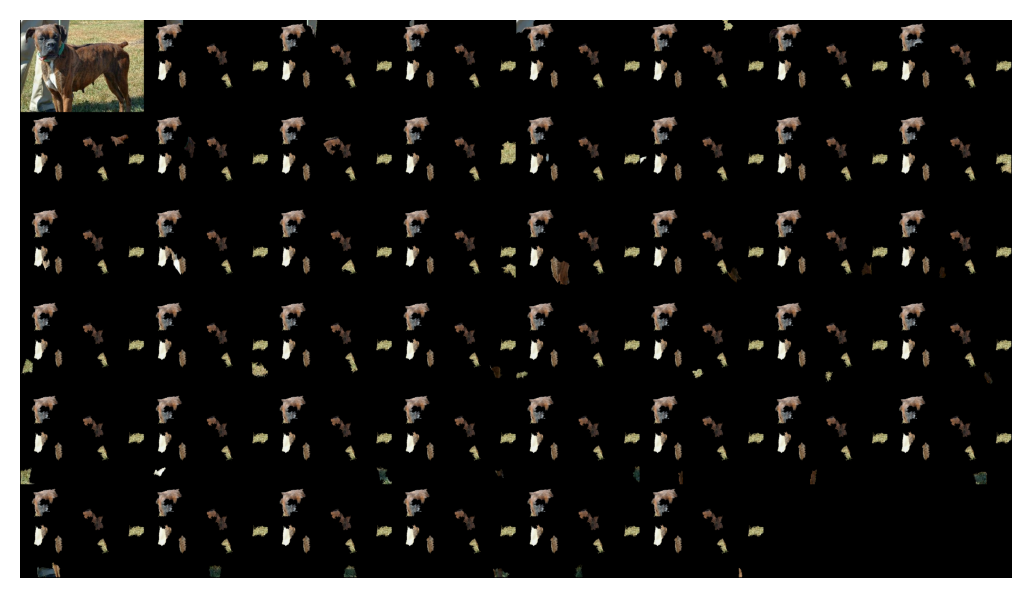

In [ ]:
edcs = []
for i in range(len(result)):
    edc = EdC(image, segments, result[i])
    edcs.append(edc)

show_batch([image] + edcs)

# Test 2

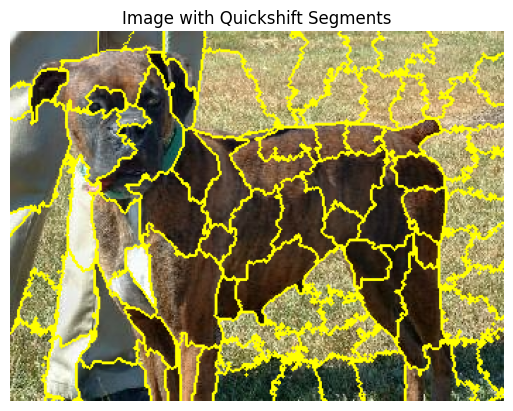

In [ ]:
image2 = images[0][0]
segments2 = segments_list[0]
show_segmented_images(image2, segments2)

In [ ]:
len(np.unique(segments2))

86

In [ ]:
result2 = SEDC(image2, classifier, segments2, transform=test_transform)

Current iter 1 (list of segments length)
Current iter 2 (list of segments length)
Current iter 3 (list of segments length)
Current iter 4 (list of segments length)
Current iter 5 (list of segments length)


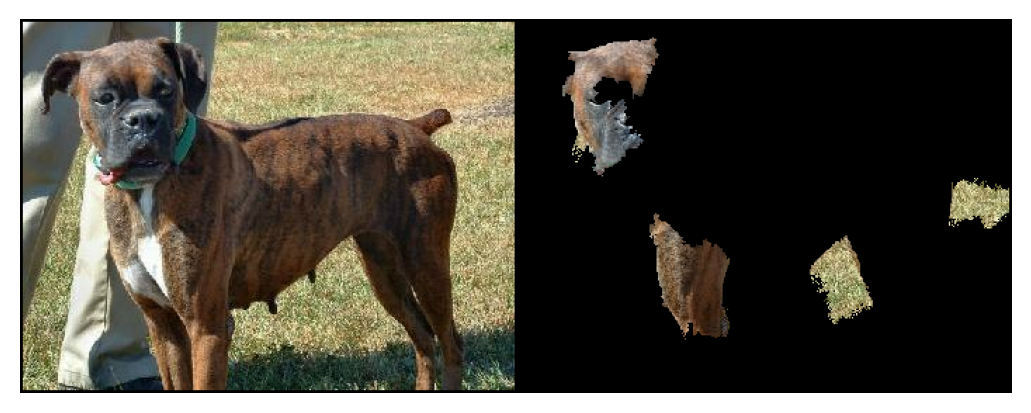

In [ ]:
edcs2 = []
for i in range(len(result2)):
    edc = EdC(image2, segments2, result2[i])
    edcs2.append(edc)

show_batch([image2] + edcs2)

# Test 3

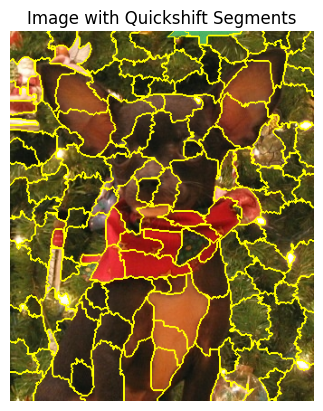

138

In [ ]:
image3 = images[1][0]
segments3 = segments_list[1]
show_segmented_images(image3, segments3)
len(np.unique(segments3))

Current iter 1 (list of segments length)
Current iter 2 (list of segments length)
Current iter 3 (list of segments length)
Current iter 4 (list of segments length)
Current iter 5 (list of segments length)
Current iter 6 (list of segments length)


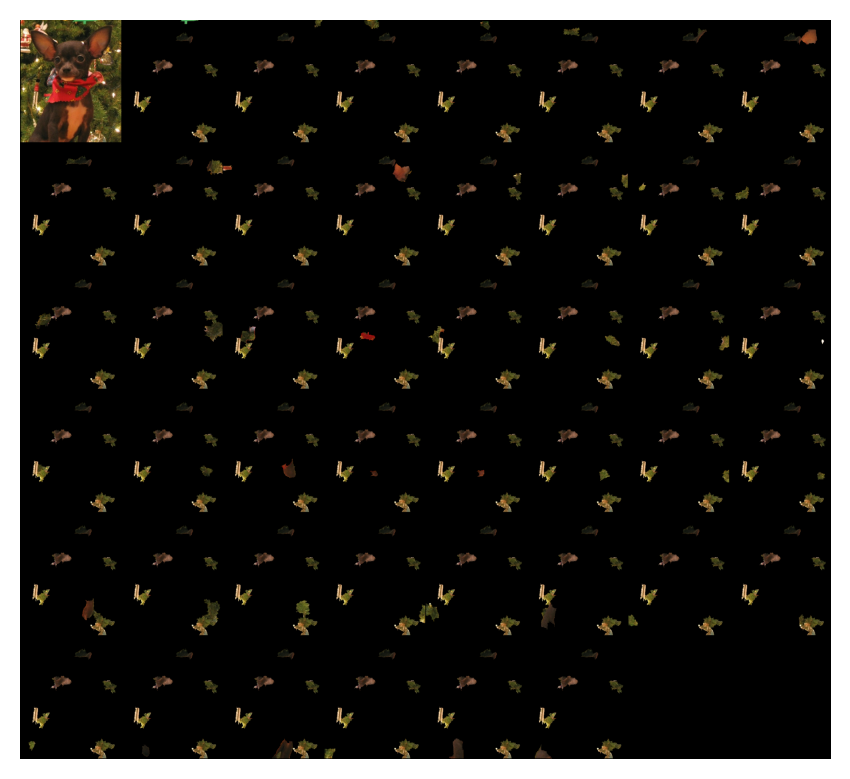

In [ ]:
result3 = SEDC(image3, classifier, segments3, transform=test_transform)
edcs3 = []
for i in range(len(result3)):
    edc = EdC(image3, segments3, result3[i])
    edcs3.append(edc)

show_batch([image3] + edcs3)

# SEDCT
Multiclass variant (to test)

In [ ]:
# Utility functions for multiclass classification
from torchvision.transforms.functional import to_pil_image
import time

def pred_score_T(image, classifier, target = None, transform = None):
    # Image conversion and transformation
    if transform:
        image = to_pil_image(image)
        transformed_image = transform(image)

    transformed_image = transformed_image.unsqueeze(0).to(DEVICE) 
    classifier.to(DEVICE)

    classifier.eval()
    with torch.no_grad():
        time1 = time.time() 
        output = classifier(transformed_image)
        time2 = time.time()
        
        print("Time taken for prediction: ", time2 - time1)

        probabilities = torch.softmax(output, dim=1)
        
        pred = torch.argmax(probabilities).item() # Predicted class

        score = probabilities[0][pred].item() # Score of predicted class

        if target is not None:
            target_score = probabilities[0][target].item() # Score of target class
        #score = output.item()
        #pred = 1 if score > 0.5 else 0
    classifier.train()

    #if pred == 0:
    #    score = 1 - score
    
    if target is not None:
        return pred, score, target_score

    return pred, score 


In [ ]:
def SEDCT (image, classifier, segments, target, transform=None, max_iter=20):
    # Image prediction and score
    #c, p_c = pred_score_T(image, classifier, transform)  # TODO to modify, doesn't work rn
    # Target class
    t = target
    # List of EdCs
    R = []
    # List of combinations to expand on
    C = []
    # List of difference between target class and predicted class score
    P = []

    # List of segment ids
    segment_ids = np.unique(segments)

    # Support percentage of segments
    if max_iter < 1:
        iters = int(len(segment_ids) * max_iter)
        max_iter = iters

    # First loop
    for id in segment_ids:
        # Remove one segment
        new_image = remove_segment(image, segments, id)
        # New prediction and new score
        c_new, p_c_new, p_t_new = pred_score_T(new_image, classifier, target=t, transform=transform)  
        
        if c_new == t:
            # If the class changes, add the index of the region to R
            R.append(id)
        else:
            # If the class doesn't change, add the index to C and compute the score reduction
            C.append(id)
            P.append(p_t_new - p_c_new)


    # While loop if no segment alone changed the classification
    iter = 0
    while not R:
        # Picking the id of the best score reduction segment
        k = np.argmax(P)
        if iter == 0:
            best = []
            best.append(C[k])
        else:
            best = C[k]

        # All expansions of "best" with one segment
        best_set = []
        for id in segment_ids:
            if id not in best:
                temp = best.copy()
                temp.append(id)
                best_set.append(temp)
        # Pruning step
        C.pop(k)
        P.pop(k)
        # Second loop
        for id_list in best_set:
            # Remove the segments
            new_image = remove_segment(image, segments, id_list)
            # New prediction and new score
            c_new, p_c_new, p_t_new = pred_score_T(new_image, classifier, target=t, transform=transform)
            
            if c_new != t:
                # If the class changes, add the index of the region to R
                R.append(id_list)
            else:
                # If the class doesn't change, add the index to C and compute the score reduction
                C.append(id_list)
                P.append(p_t_new - p_c_new)

        # Output control
        iter += 1
        print(f"Current iter {iter} (list of segments length)")
        if iter >= max_iter:
            print("Max iterations reached")
            break

    return R

### Torch dataset

In [ ]:
from torchvision.datasets import Flowers102

# Transformations
train_transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the datset
f_dataset_train = Flowers102(root='./data', split='train', download=True)
f_dataset_test = Flowers102(root='./data', split='test', download=True)

  2%|▏         | 6.62M/345M [00:13<11:07, 507kB/s]


KeyboardInterrupt: 

In [ ]:
import os
import scipy.io
from PIL import Image

class CustomFlowers102Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', transform=None, limit_classes=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.limit_classes = limit_classes

        # Load the .mat files for labels and splits
        labels_mat = scipy.io.loadmat(os.path.join(root_dir, 'imagelabels.mat'))
        setid_mat = scipy.io.loadmat(os.path.join(root_dir, 'setid.mat'))

        self.image_labels = labels_mat['labels'][0] - 1  # Convert to 0-based indexing
        self.image_names = [f"image_{i+1:05d}.jpg" for i in range(len(self.image_labels))]
        
        self.train_set = setid_mat['trnid'][0] - 1  # Train indices (0-based)
        self.test_set = setid_mat['tstid'][0] - 1   # Test indices (0-based)

        # Filter to only use the first N classes if specified
        self.selected_classes = sorted(set(self.image_labels))[:self.limit_classes] if self.limit_classes else sorted(set(self.image_labels))

        # Filter based on the split
        if self.split == 'train':
            self.indices = self.train_set
        elif self.split == 'test':
            self.indices = self.test_set
        else:
            raise ValueError("split must be 'train' or 'test'")

        # Apply class filtering
        self.filtered_image_names = [
            (name, label) for name, label in zip(self.image_names, self.image_labels)
            if label in self.selected_classes and np.where(self.image_labels == label)[0][0] in self.indices
        ]
    
    def __len__(self):
        return len(self.filtered_image_names)
    
    def __getitem__(self, idx):
        # Get the image path and label
        image_name, label = self.filtered_image_names[idx]
        image_path = os.path.join(self.root_dir, 'jpg', image_name)

        # Open the image
        image = Image.open(image_path).convert('RGB')

        # Apply the transformation (e.g., resize, normalize)
        if self.transform:
            image = self.transform(image)
        
        return image, label



# Create datasets
f_train_set = CustomFlowers102Dataset(root_dir='./data/flowers-102', split='train', transform=train_transform2, limit_classes=10)
f_test_set = CustomFlowers102Dataset(root_dir='./data/flowers-102', split='test', transform=test_transform2, limit_classes=10)

In [ ]:
len(f_train_set), len(f_test_set)

(0, 482)

In [ ]:
f_test_set[0][0].shape, f_test_set[0][1]

(torch.Size([3, 128, 128]), np.uint8(7))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.78039217..0.9764706].


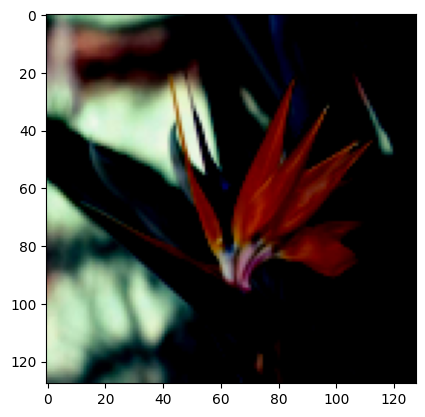

In [ ]:
image = f_test_set[0][0]
plt.imshow(image.permute(1, 2, 0))

In [ ]:
# Dataloaders
f_train_loader = torch.utils.data.DataLoader(f_train_set, 
                                             batch_size=32, 
                                             shuffle=True, 
                                             drop_last=True)

f_test_loader = torch.utils.data.DataLoader(f_test_set,
                                            batch_size=32, 
                                            shuffle=False, 
                                            drop_last=False)

### tfds

In [ ]:
f_dataset = tfds.load("tf_flowers", as_supervised=True, split=['train[:80%]', 'train[80%:]'])

# Transformations
train_transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Train and test sets
f_train_set = ConversionToTorchDataset(f_dataset[0], transform=train_transform2)
f_test_set = ConversionToTorchDataset(f_dataset[1], transform=test_transform2)

# Train and test loaders
f_train_loader = torch.utils.data.DataLoader(f_train_set,
                                             batch_size=32,
                                             shuffle=True,
                                             drop_last=True)

f_test_loader = torch.utils.data.DataLoader(f_test_set,
                                            batch_size=32,
                                            shuffle=False,
                                            drop_last=False)

2025-04-30 17:26:21.127233: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-04-30 17:26:22.564208: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-30 17:26:23.080631: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
import torchvision.models as models

multi_classifier = models.resnet18(pretrained=True)

num_classes = 5
multi_classifier.fc = torch.nn.Linear(multi_classifier.fc.in_features, num_classes)


/Users/zenna/miniconda3/envs/sedct/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zenna/miniconda3/envs/sedct/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define DEVICE with priority: MPS > CUDA > CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)


multi_classifier.to(DEVICE)

loss_fun = torch.nn.CrossEntropyLoss()
loss_fun.to(DEVICE)

LR = 0.001
optimizer = torch.optim.Adam(multi_classifier.parameters(), lr=LR)

mps


In [ ]:
# Training 
EPOCHS = 5

step = 0
multi_classifier.train()
for epoch in range(EPOCHS):
  # Training loop
  for images, labels in f_train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Reset the gradient
    optimizer.zero_grad()

    # Compute the prob
    logits = multi_classifier(images)
    
    # Compute the loss
    loss = loss_fun(logits, labels)

    # Backward step
    loss.backward()

    # Optimizer step
    optimizer.step()

    step += 1
    if step % 50 == 0:
      acc = (torch.argmax(logits, dim=1) == labels).float().mean().item()
      print(f"{step}[{epoch}]: loss {loss.item():.4f}   acc:{100*acc:.1f}")

  # Save the model parameters every epoch
  torch.save(multi_classifier.state_dict(), "multi_classifier.pt")

50[0]: loss 0.5387   acc:81.2
100[1]: loss 0.3253   acc:90.6
150[1]: loss 0.4406   acc:81.2
200[2]: loss 0.0568   acc:96.9
250[2]: loss 0.2172   acc:90.6
300[3]: loss 0.2827   acc:90.6
350[3]: loss 0.1650   acc:93.8
400[4]: loss 0.3111   acc:87.5
450[4]: loss 0.0472   acc:96.9


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluation
multi_classifier.eval() 

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in f_test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = multi_classifier(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')  

print(f"Test Accuracy: {acc*100:.2f}%")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 90.60%
Test F1 Score: 0.9064


### Load model

In [ ]:
# Load the saved model parameters
multi_classifier.load_state_dict(torch.load("multi_classifier.pt", map_location=DEVICE))
multi_classifier.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# test 1

In [ ]:
f_images = ConversionToTorchDataset(f_dataset[0].take(1))

In [ ]:
f_segments_list = create_segments(f_images, kernel_size=6, max_dist=30, ratio=0.3)

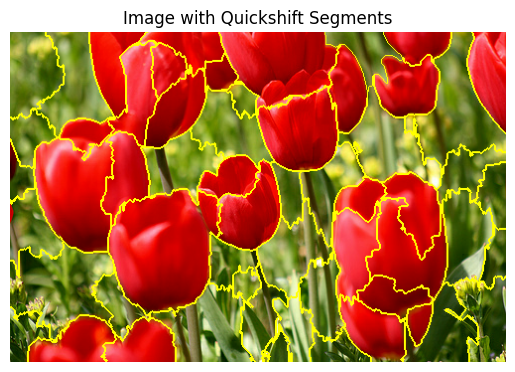

In [ ]:
f_image0 = f_images[0][0]
f_segments0 = f_segments_list[0]

show_segmented_images(f_image0, f_segments0)

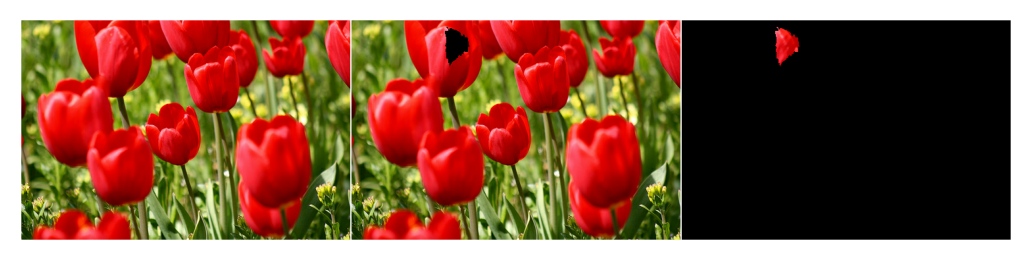

Image label: 2


In [ ]:
f_removed_image = remove_segment(f_image0, f_segments0, 5)
f_edc = EdC(f_image0, f_segments0, 5)
show_batch([f_image0, f_removed_image, f_edc])
# Print image label
print(f"Image label: {f_images[0][1]}")

In [ ]:
f_results_class1 = SEDCT(f_image0, multi_classifier, f_segments0, target=1, transform=test_transform2)

Time taken for prediction:  0.39215898513793945
Time taken for prediction:  0.011854887008666992
Time taken for prediction:  0.005738019943237305
Time taken for prediction:  0.0060138702392578125
Time taken for prediction:  0.009045124053955078
Time taken for prediction:  0.0055811405181884766
Time taken for prediction:  0.008491992950439453
Time taken for prediction:  0.006192207336425781
Time taken for prediction:  0.008533954620361328
Time taken for prediction:  0.005118131637573242
Time taken for prediction:  0.005979776382446289
Time taken for prediction:  0.00506591796875
Time taken for prediction:  0.005413055419921875
Time taken for prediction:  0.004601240158081055
Time taken for prediction:  0.007554769515991211
Time taken for prediction:  0.00493168830871582
Time taken for prediction:  0.004854917526245117
Time taken for prediction:  0.005053997039794922
Time taken for prediction:  0.0050852298736572266
Time taken for prediction:  0.004328250885009766
Time taken for predicti

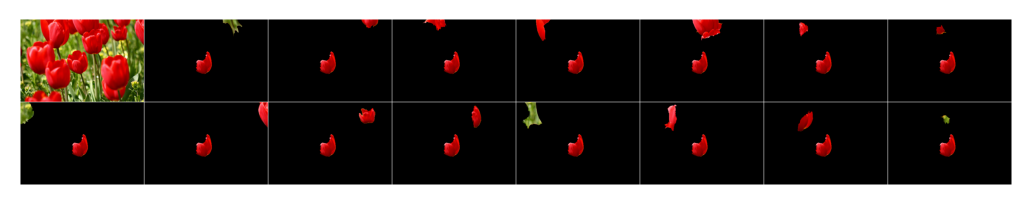

In [ ]:
f_results_class1 = f_results_class1[:15]

f_edcs = []
for i in range(len(f_results_class1)):
    f_edc = EdC(f_image0, f_segments0, f_results_class1[i])
    f_edcs.append(f_edc)

show_batch([f_image0] + f_edcs)

In [ ]:
f_results_class4 = SEDCT(f_image0, multi_classifier, f_segments0, target=4, transform=test_transform2)

Current iter 1 (list of segments length)


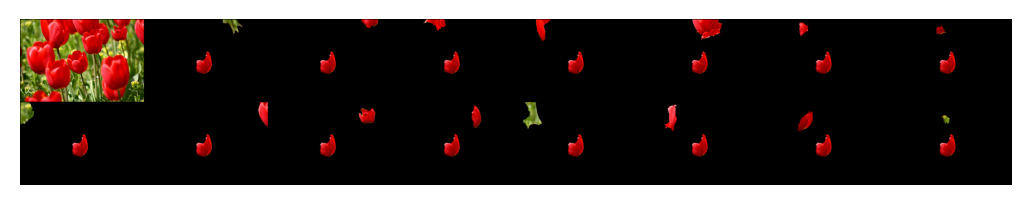

In [ ]:
f_results_class4 = f_results_class4[:15]

f_edcs = []
for i in range(len(f_results_class4)):
    f_edc = EdC(f_image0, f_segments0, f_results_class4[i])
    f_edcs.append(f_edc)

show_batch([f_image0] + f_edcs)

# test 2

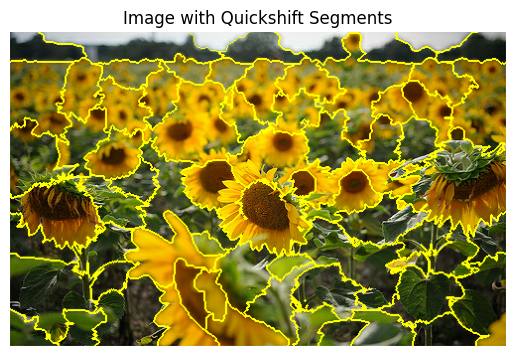

Image label: 3


In [ ]:
f_image1 = f_images[4][0]
f_segments1 = f_segments_list[4]

show_segmented_images(f_image1, f_segments1)
print(f"Image label: {f_images[4][1]}")

Current iter 1 (list of segments length)


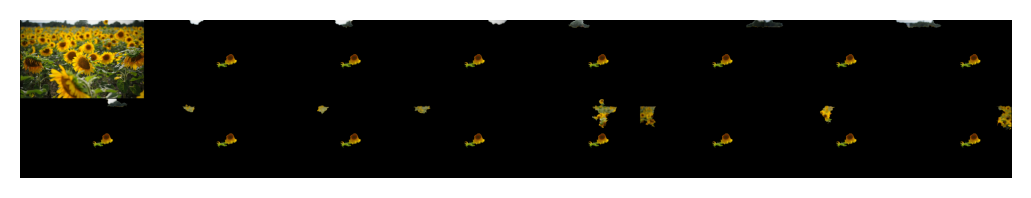

In [ ]:
f_results_class0 = SEDCT(f_image1, multi_classifier, f_segments1, target=0, transform=test_transform2)
f_results_class0 = f_results_class0[:15]

f_edcs = []
for i in range(len(f_results_class0)):
    f_edc = EdC(f_image1, f_segments1, f_results_class0[i])
    f_edcs.append(f_edc)

show_batch([f_image1] + f_edcs)

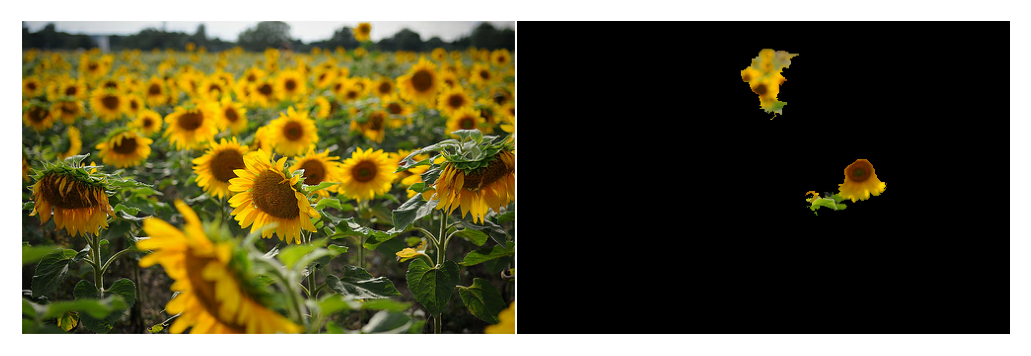

In [ ]:
show_batch([f_image1] + [f_edcs[13]])

Current iter 1 (list of segments length)


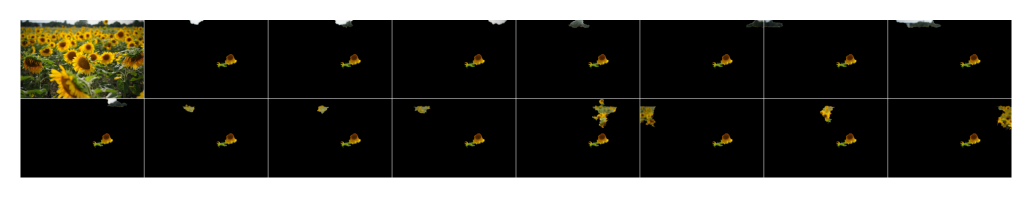

In [ ]:
f_results_class1 = SEDCT(f_image1, multi_classifier, f_segments1, target=1, transform=test_transform2)

f_results_class1 = f_results_class1[:15]
f_edcs = []
for i in range(len(f_results_class1)):
    f_edc = EdC(f_image1, f_segments1, f_results_class1[i])
    f_edcs.append(f_edc)

show_batch([f_image1] + f_edcs)